# Notebook for plotting

Before you can run this notebook you should run our model. You can find the run_model script in the `scripts/run_on_cluster` folder.



In [1]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19

In [2]:
%load_ext autoreload
%autoreload 2

Some general configs for matplotlib and file loading, you normally shouldn't need to change anything here except maybe the simulation parameters, if you changed them.

In [2]:
""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

""" Colors
Done with rcParams / see plot.rcParams
"""


""" General configs
"""
fig_path = "./figures"
countries = ["England","Scotland","Germany","France"]
xlim_ts = [datetime.datetime(2021,5,30),datetime.datetime(2021,7,23)] # Plotting range
tune = 200
draws = 300 
max_treedepth = 10
offset = 0 #offset of soccer games, mainly for sanity checks
width_prior_delay = 0.1

ylims_fraction = { #ylims for fraction plots
    "Germany":[0.8,1.7],
    "Scotland":[0.8,2.3],
    "England":[0.9,1.4],
    "France":[0.65,1.35],
}
ylims_cases = {
    "Germany":[0,200],
    "Scotland":[0,1100],
    "England":[0,1100],
    "France":[0,500],
}
# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}

Next we load all traces from the simulations. Check the path and simulation parameters if you can't load them here.

In [3]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

## Single plots

Uncomment function calls below to generate them (output is writen to the `fig_path` folder

## Main figure (overview)

Load the four main model runs, i.e. with default parameters:

In [4]:
countries = ["England","Scotland","Germany","France"]
tune = 200
draws = 300
max_treedepth = 10
traces, models, dls = [], [], []
for country in countries:
    #'UEFA-beta=False-country=England-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-tune=200-draws=300-max_treedepth=10.pickled'
    fstr=(f"/data.nst/jdehning/covid_uefa_traces8/UEFA"+
        f"-beta=True"+
        f"-country={country}"+
        f"-offset_games=0"+
        f"-draw_delay=True"+
        f"-weighted_alpha_prior=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-tune={tune}"+
        f"-draws={draws}"+
        f"-max_treedepth={max_treedepth}.pickled")
    model, trace = load(fstr)
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

Create multi overview plot for all four model runs:

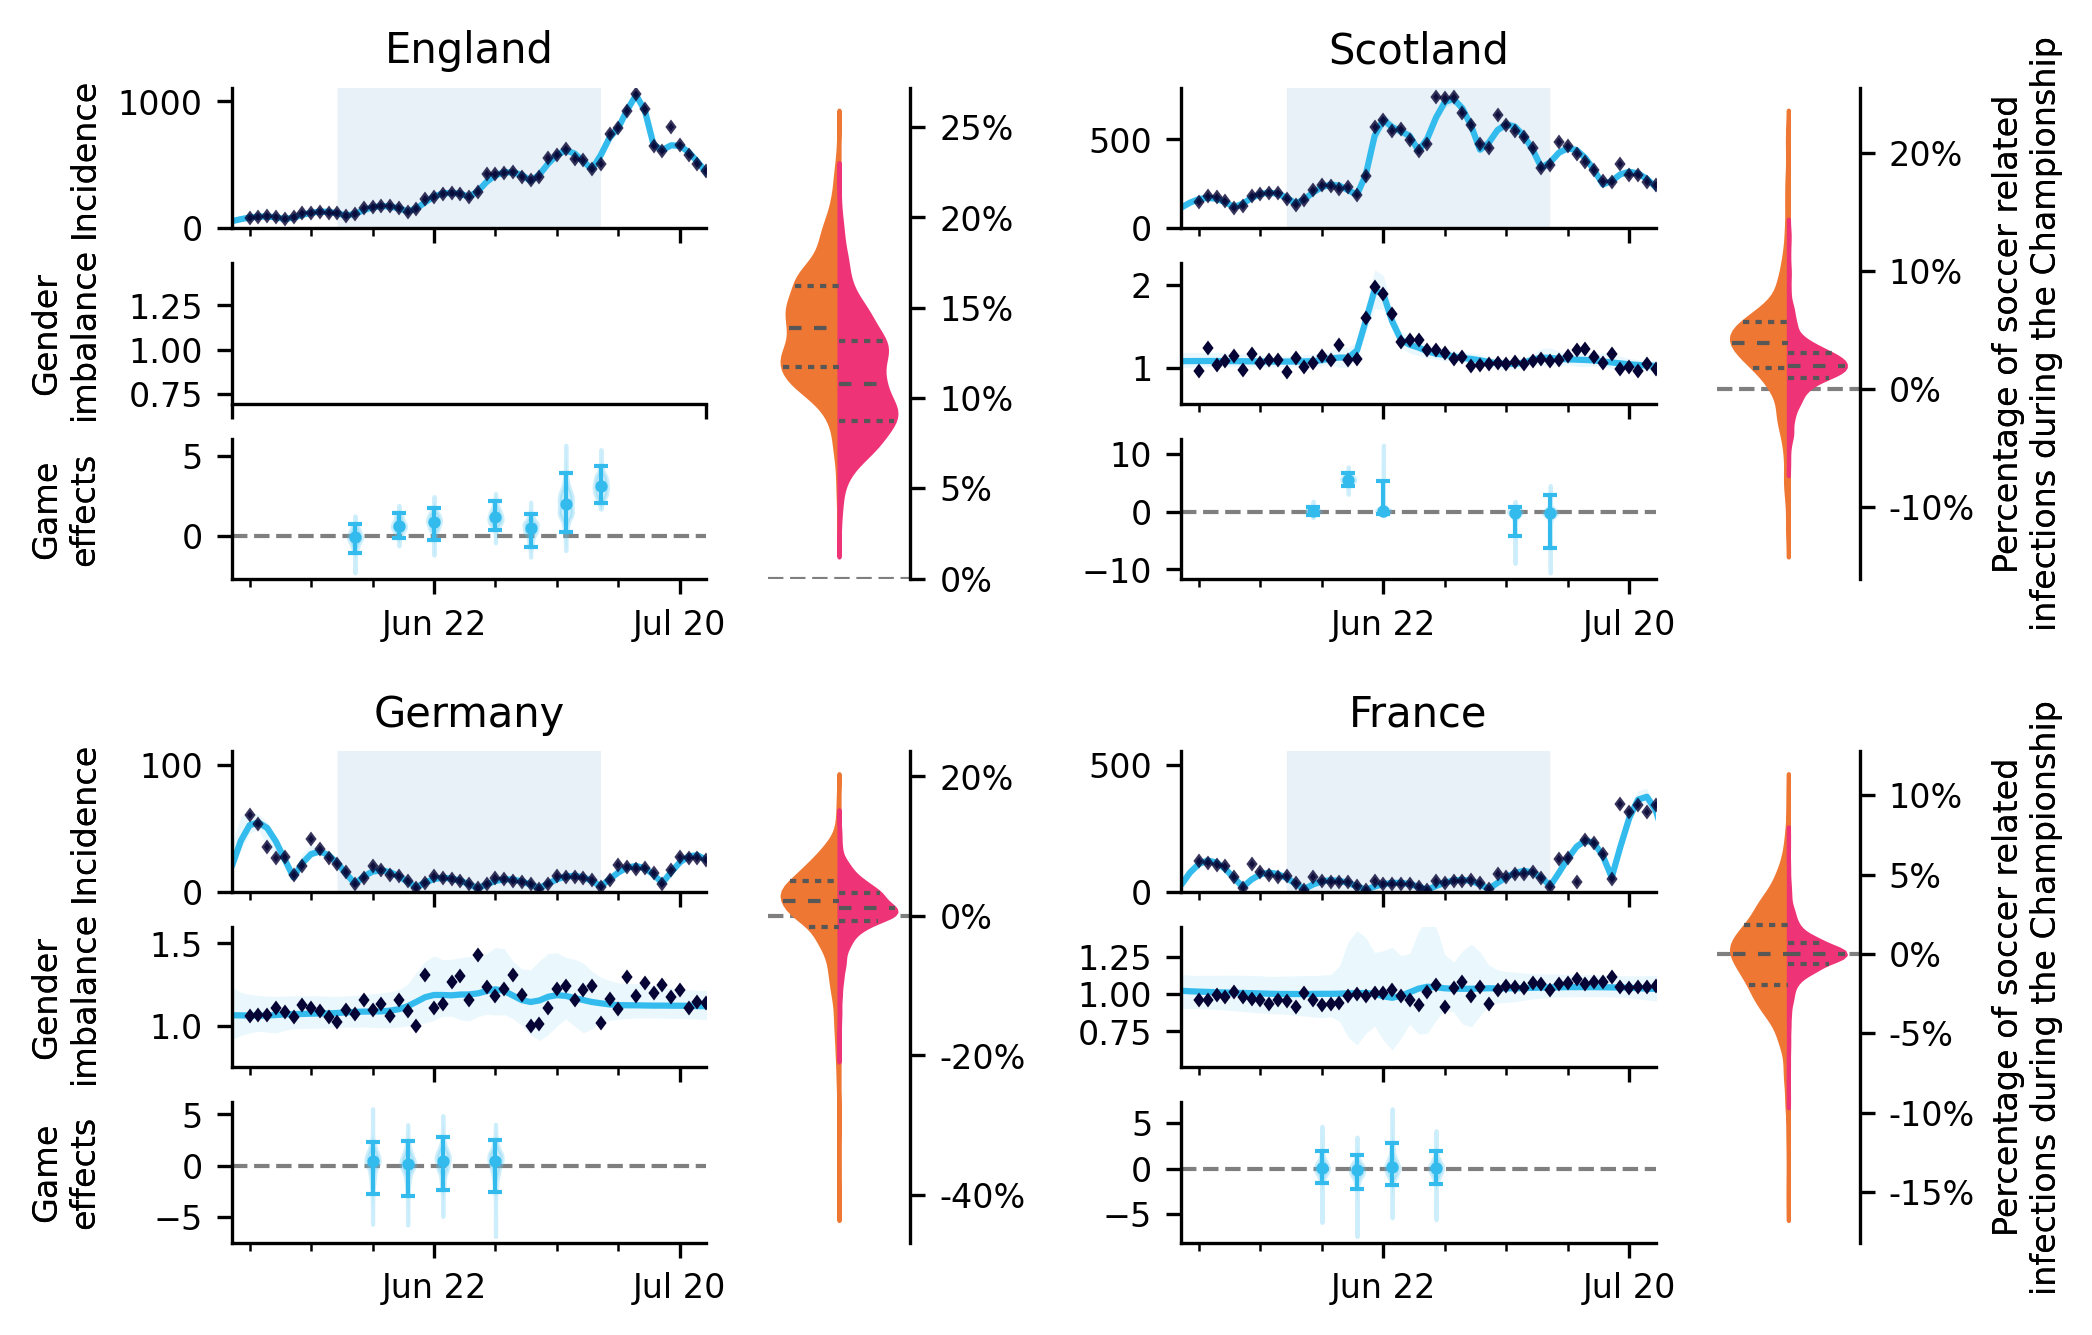

In [6]:
axes = covid19_soccer.plot.overview.multi(traces,models,dls,plot_beta=False,xlim=xlim_ts)

# We can apply more markup to the axes here:
#axes[0][1].set_ylim(-10,10)
axes[2][1].set_ylim(0.75,1.6)
axes[3][1].set_ylim(0.51,1.45)
#axes[2][2].set_ylim(-10,10)
axes[0][-1].set_xlim(-1,2)

# Show and save plot
fig = axes[0][0].get_figure()
plt.show()
#fig.savefig(f"{fig_path}/overview.pdf", **save_kwargs)
#fig.savefig(f"{fig_path}/overview.png", **save_kwargs)
plt.close(fig=fig)

To later insert to legend with affinity or illustrator, we need to create it separately 

/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:376: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(
/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:387: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(


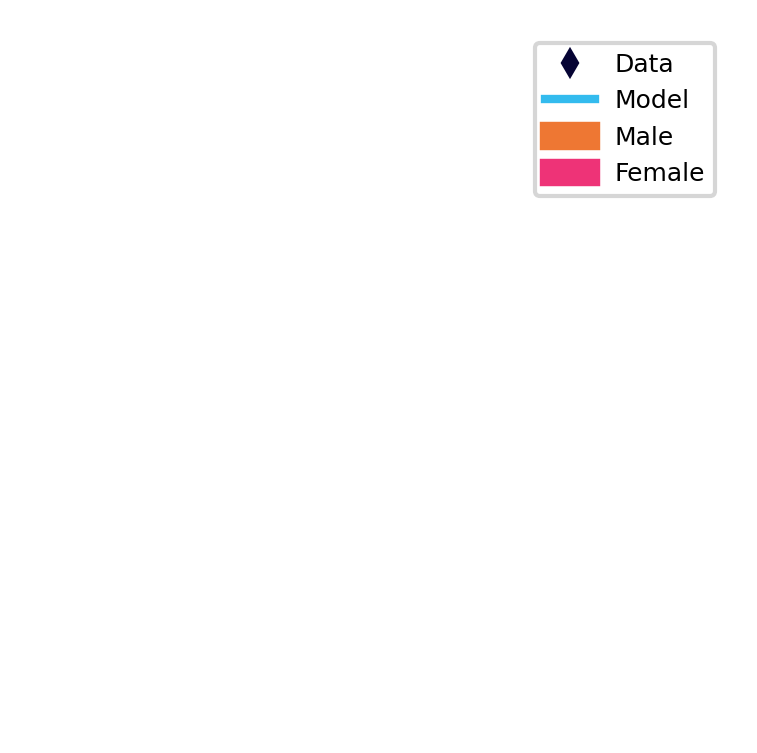

In [7]:
# Create legend
ax = covid19_soccer.plot.other.legend(prior=False,posterior=False)
fig = ax.get_figure()
fig.savefig(f"{fig_path}/legend.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/legend.png", **save_kwargs)
plt.show()
plt.close(fig=fig)

# Other distributions

We want the following distributions:

- Delay mean
- Delay width
- female factor
- normal contactmatrix offdiag


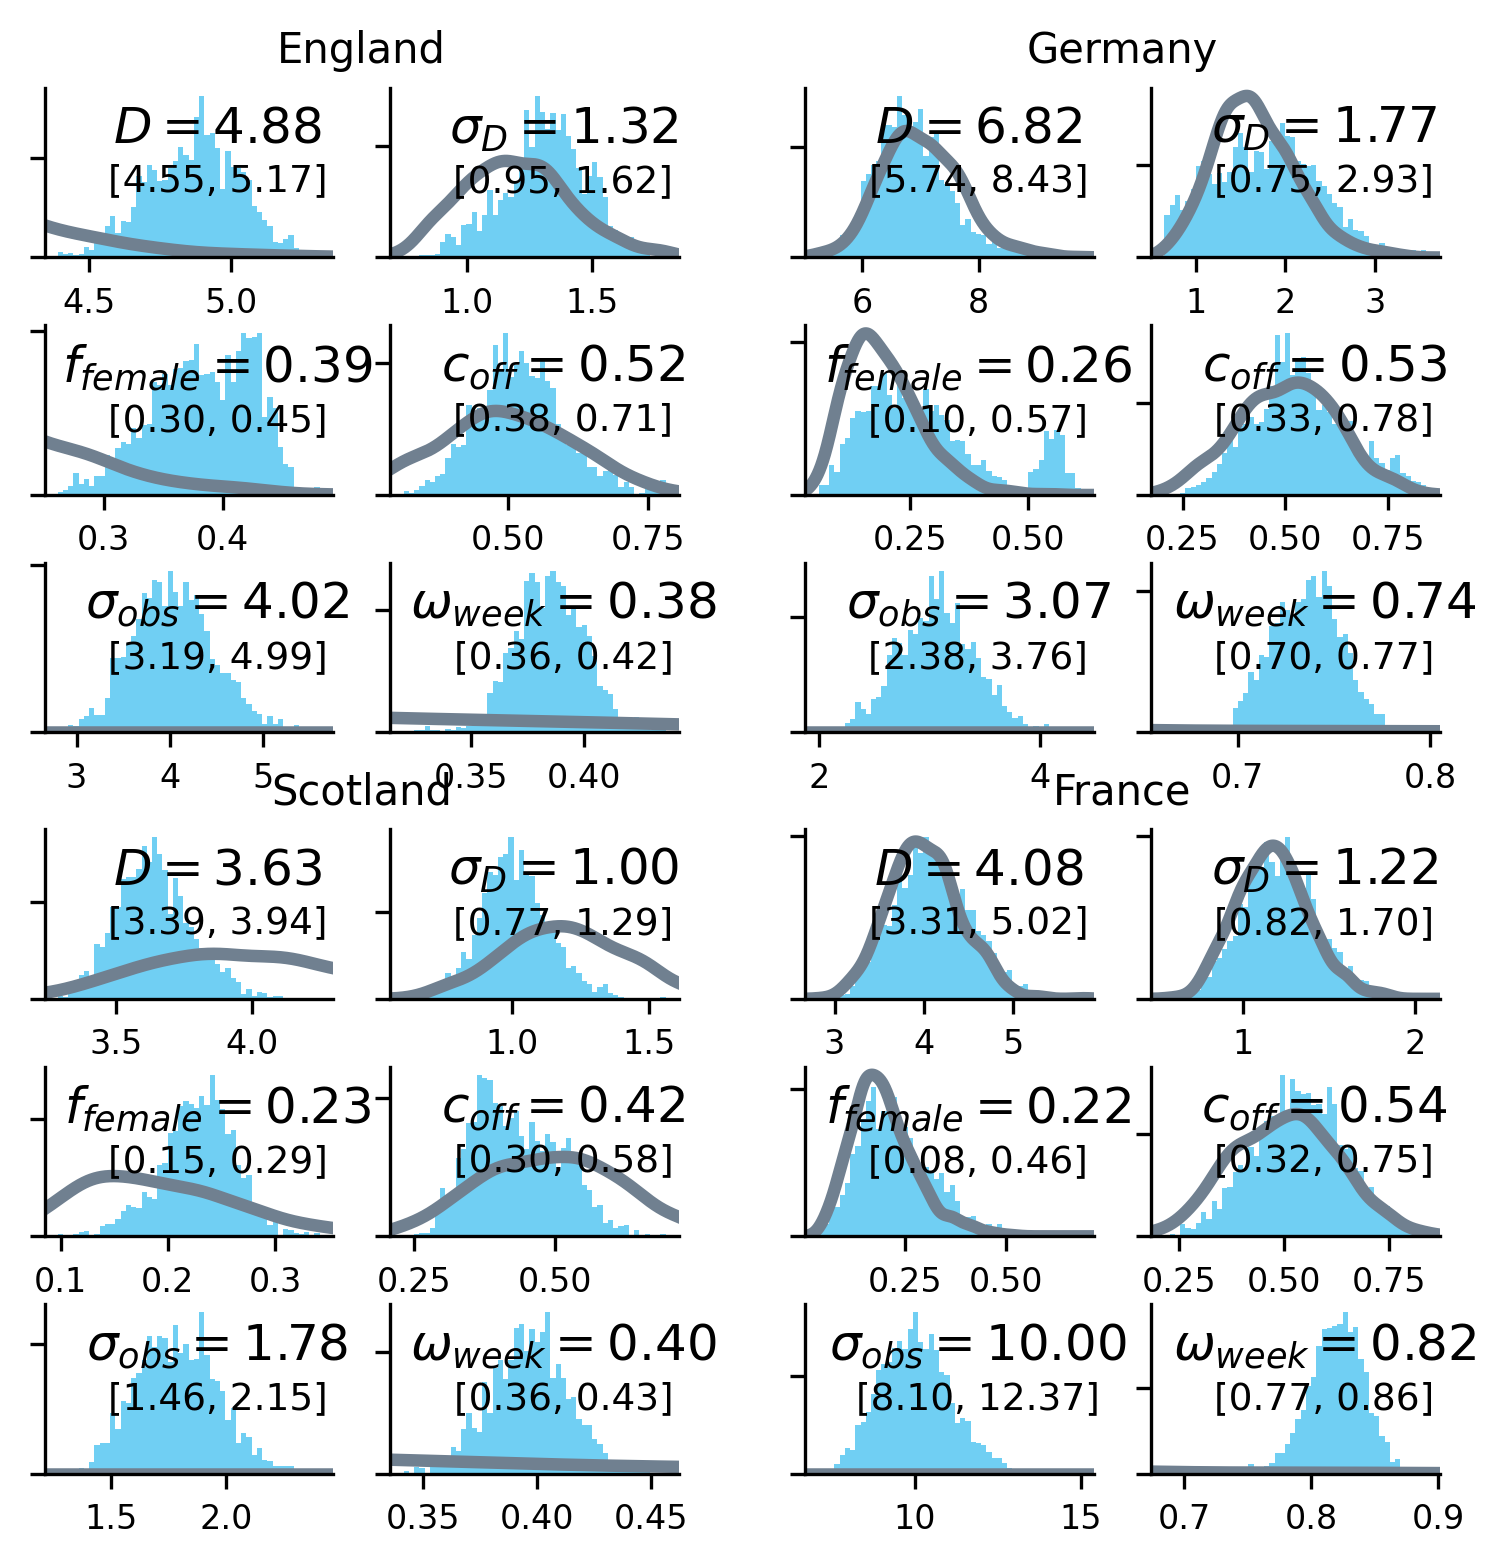

In [16]:
fig =  plt.figure(figsize=(6,6))
# Two columns/rows
outer_grid = fig.add_gridspec(2, 2, wspace=0.2, hspace=0.15,)

axes = []
for i, (trace, model, dl) in enumerate(zip(traces, models, dls)):
         # Mapping to 2d index
        a = i % 2
        b = i // 2
       
        # gridspec inside gridspec
        inner_grid = outer_grid[a,b].subgridspec(3, 2, width_ratios=[1,1],hspace=0.4,)
        country = dl.countries[0]
        
        ax = plt.Subplot(fig, outer_grid[a,b])
        ax.set_title(country)
        ax.axis('off')
        fig.add_subplot(ax)
        # Delay
        a1 = fig.add_subplot(inner_grid[0,0])
        covid19_soccer.plot.distribution(
            model,
            trace,
            "delay",
            nSamples_prior=1000,
            title="",
            dist_math="D",
            ax=a1,
        )
        
        # Delay width
        a2 = fig.add_subplot(inner_grid[0,1])
        covid19_soccer.plot.distribution(
            model,
            trace,
            "delay-width",
            nSamples_prior=1000,
            title="",
            dist_math="\sigma_D",
            ax=a2,
        )
        
        # female factor
        a3 = fig.add_subplot(inner_grid[1,0])
        covid19_soccer.plot.distribution(
            model,
            trace,
            "factor_female",
            nSamples_prior=1000,
            title="",
            dist_math="f_{female}",
            ax=a3,
        )
        
        # contact matrix offdiag
        a4 = fig.add_subplot(inner_grid[1,1])
        covid19_soccer.plot.distribution(
            model,
            trace,
            "c_off",
            nSamples_prior=1000,
            title="",
            dist_math="c_{off}",
            ax=a4,
        )

        # median_incubation
        #a5 = fig.add_subplot(inner_grid[2,0])
        #covid19_uefa.plot.distribution(
        #    model,
        #    trace,
        #    "median_incubation",
        #    nSamples_prior=1000,
        #    title="",
        #    dist_math="D_{lat}",
        #    ax=a5,
        #)
        # sigma
        a7 = fig.add_subplot(inner_grid[2,0])
        covid19_soccer.plot.distribution(
            model,
            trace,
            "sigma_obs",
            nSamples_prior=1000,
            title="",
            dist_math="\sigma_{obs}",
            ax=a7,
        )
        
        # I_begin
        a6 = fig.add_subplot(inner_grid[2,1])
        covid19_soccer.plot.distribution(
            model,
            trace,
            "weekend_factor",
            nSamples_prior=1000,
            title="",
            dist_math="\omega_{week}", #What was
            ax=a6,
        )


# Save figure as pdf and png        
kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig.savefig(f"{fig_path}/fig_distributions.pdf", **kwargs)
fig.savefig(f"{fig_path}/fig_distributions.png", **kwargs)

plt.show()
plt.close(fig=fig)

## Extended overview figures


/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/overview.py:244: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(


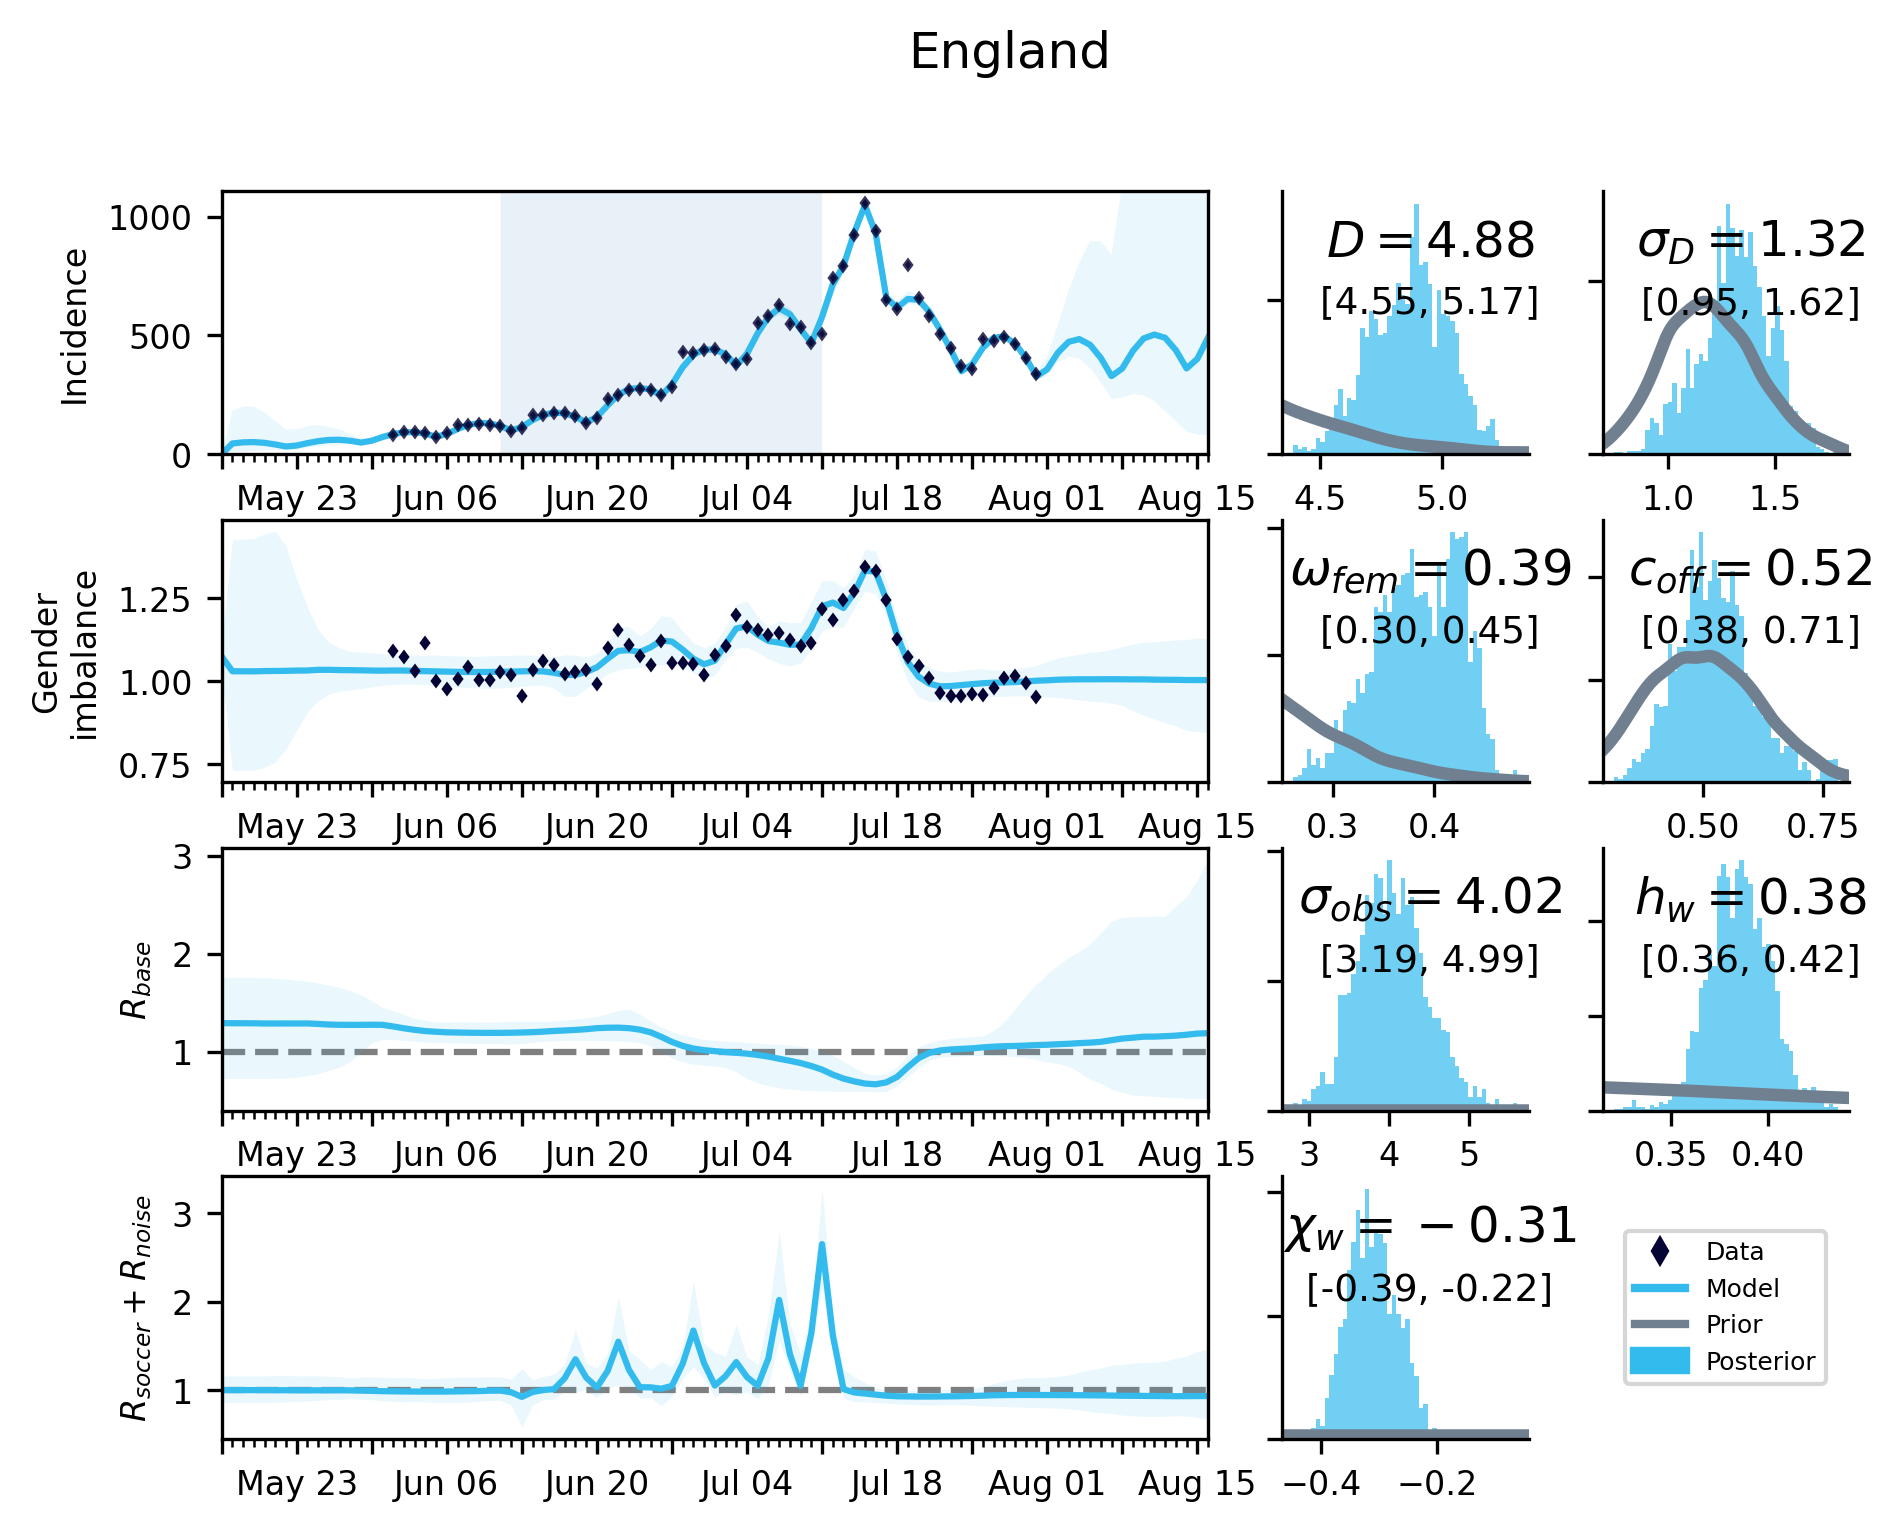

/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/overview.py:244: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(


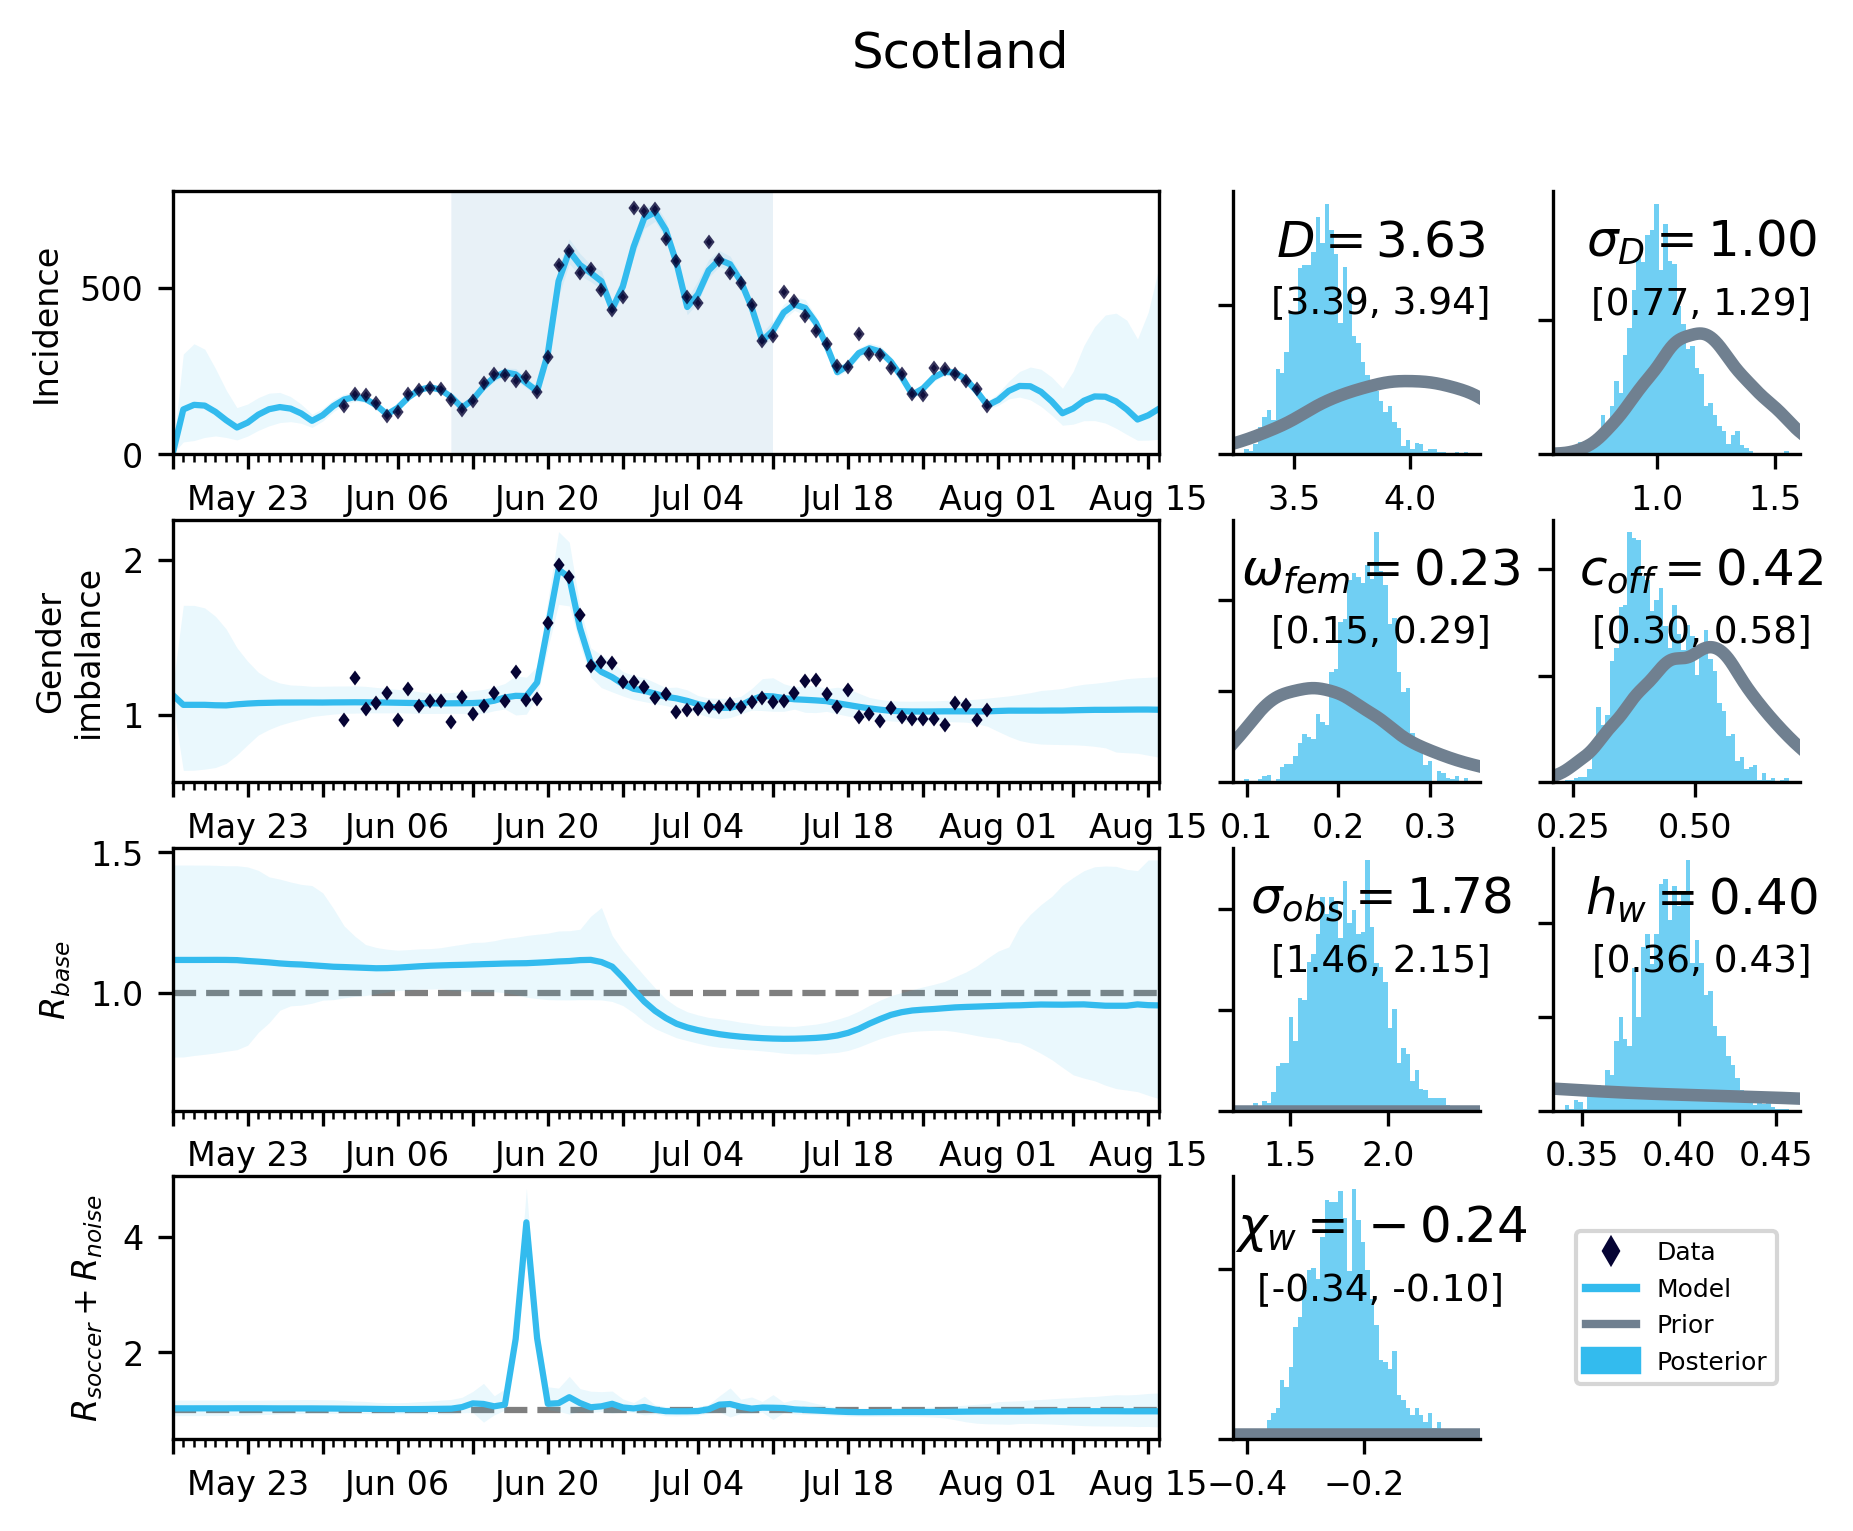

/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/overview.py:244: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(


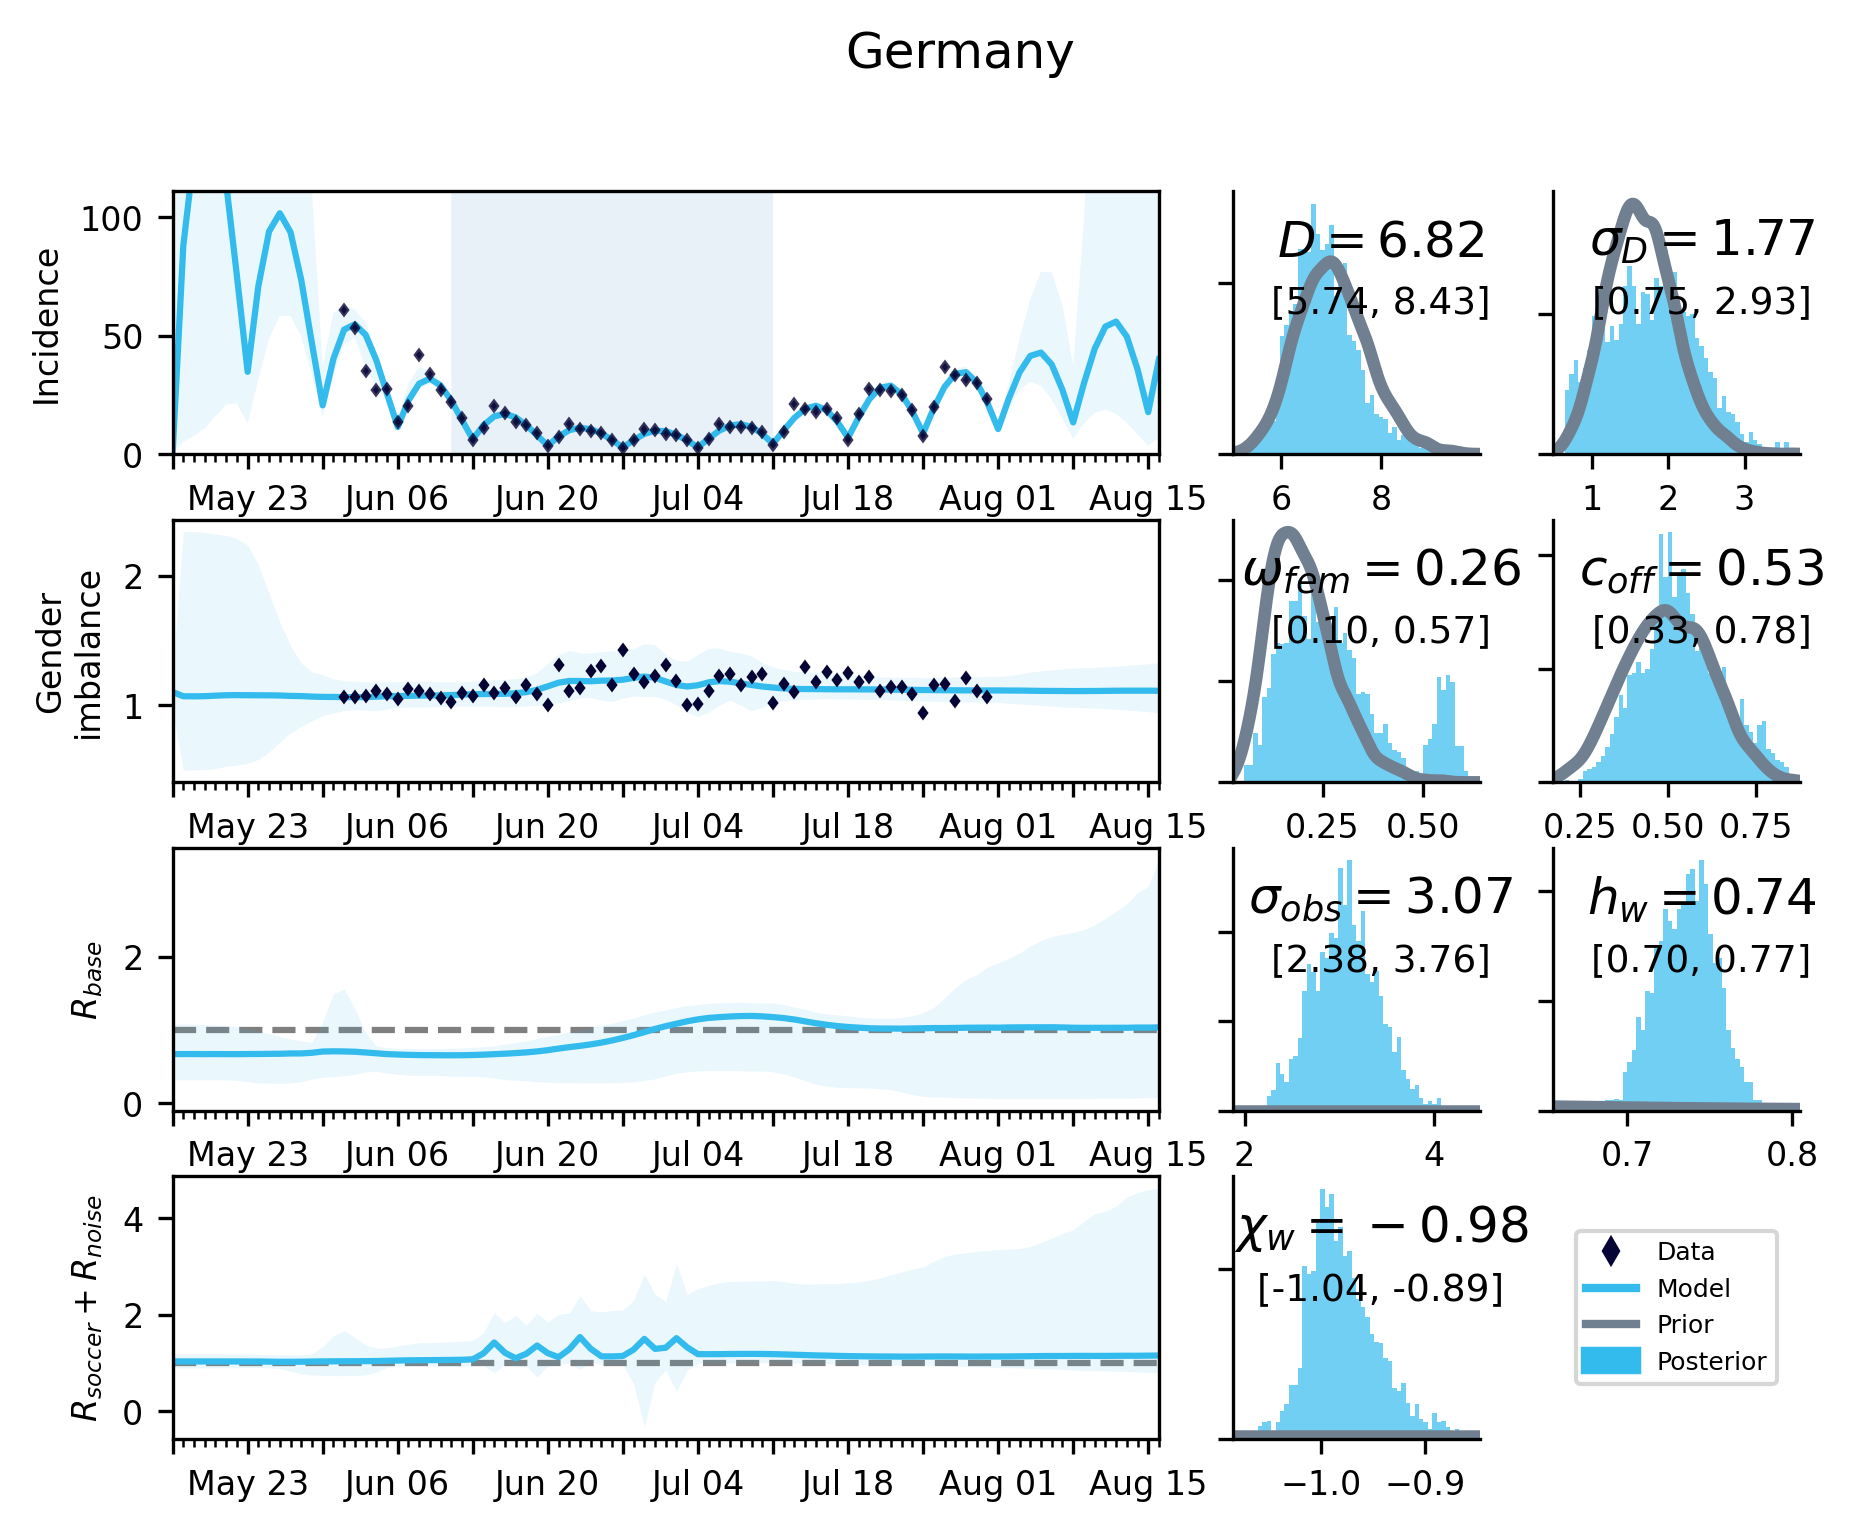

/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/overview.py:244: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(


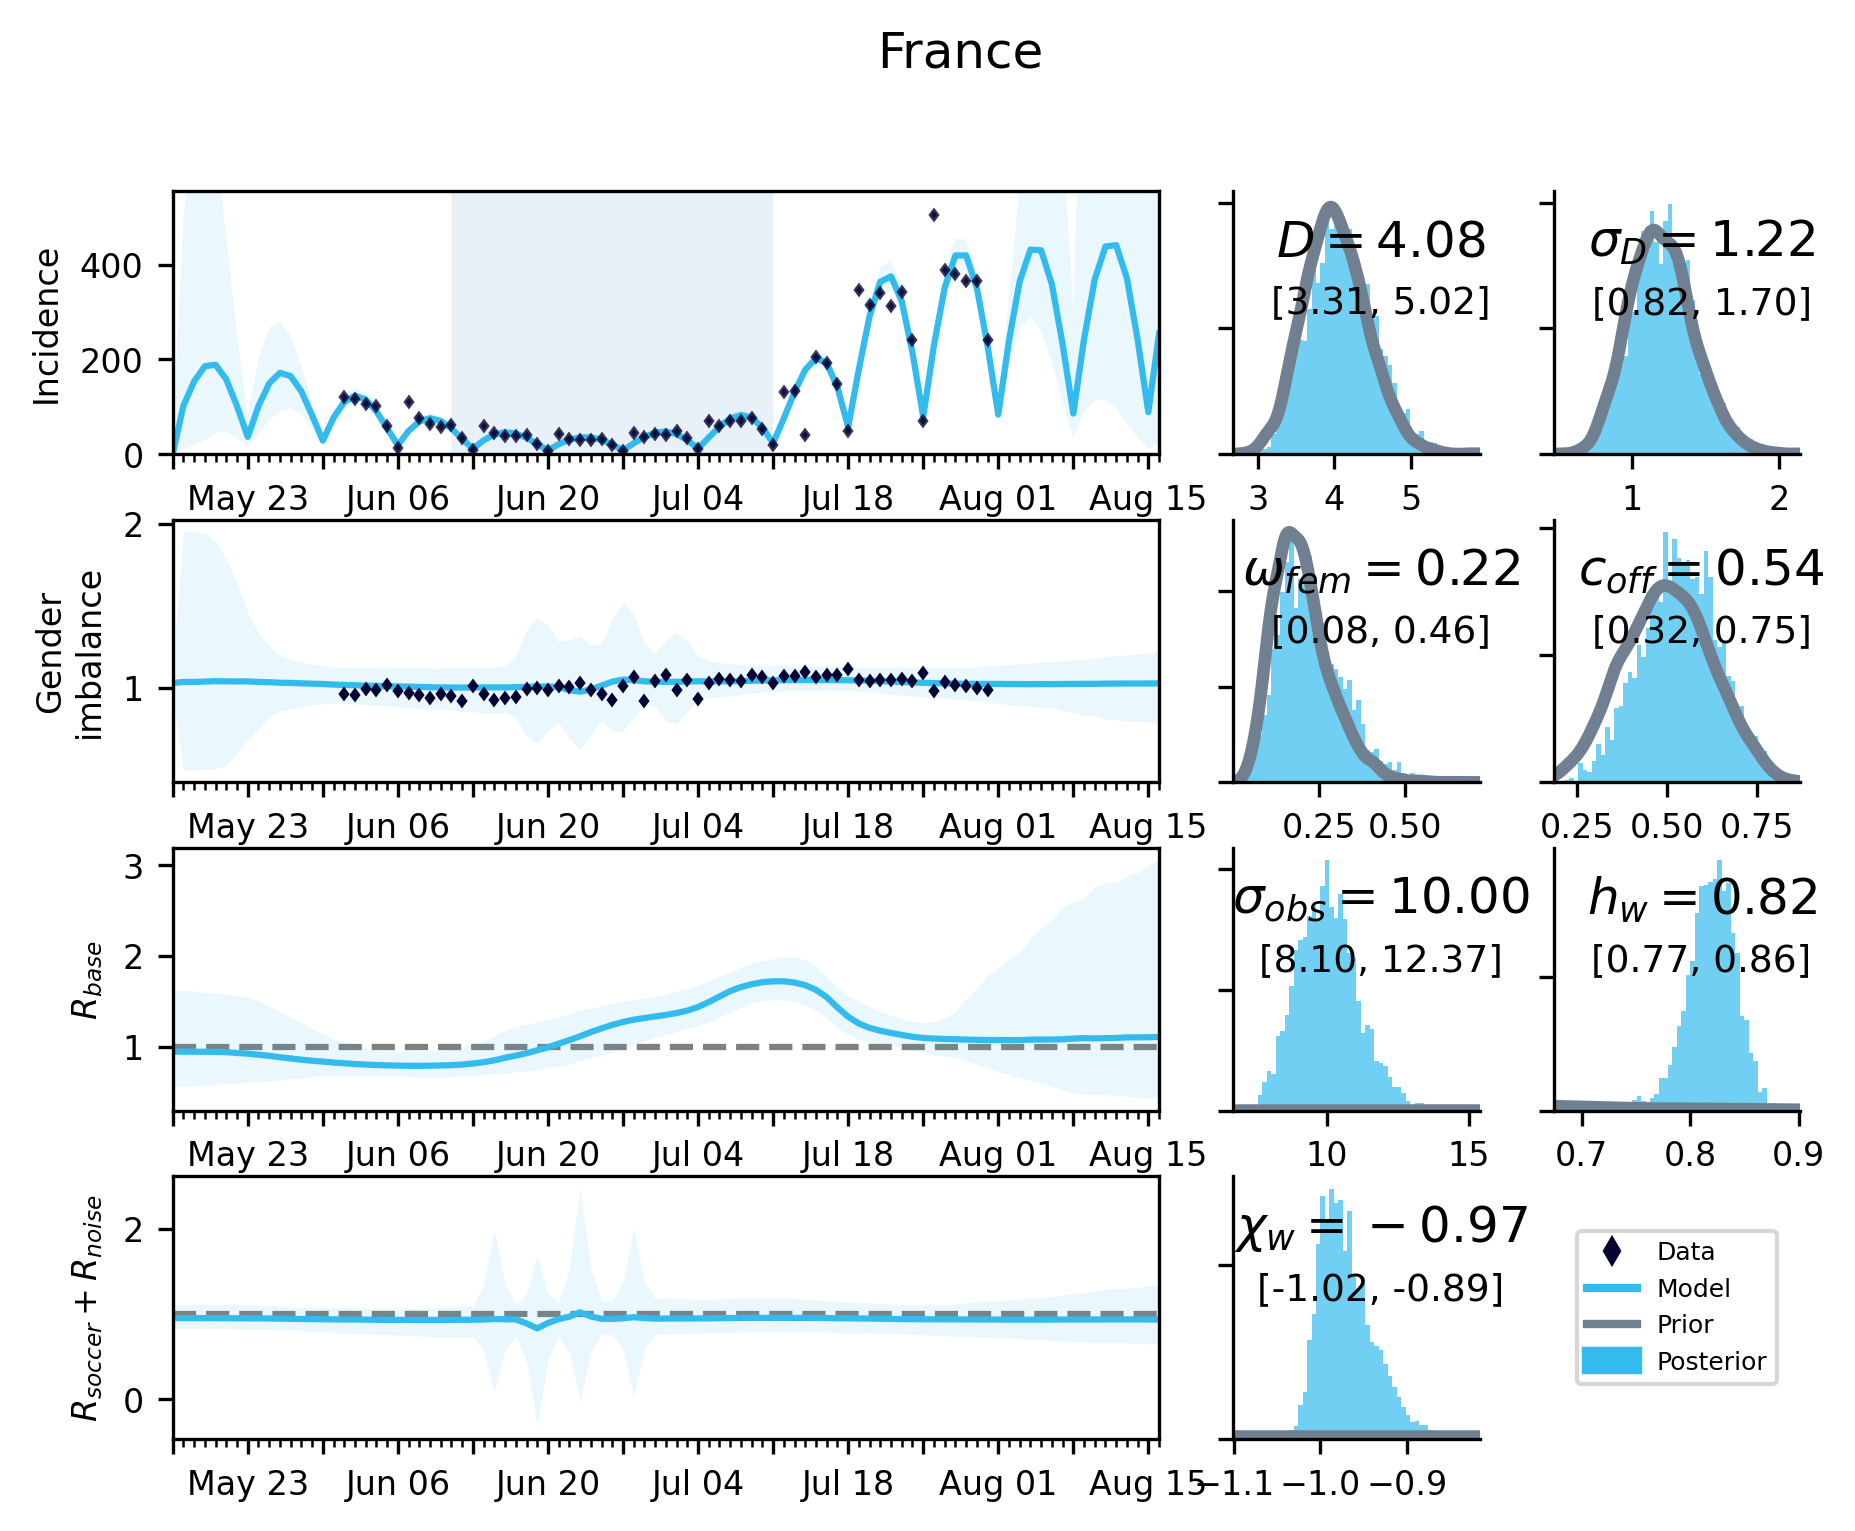

In [14]:
for i, (trace, model, dl) in enumerate(zip(traces, models, dls)):
    fig = covid19_soccer.plot.overview.single_extended(trace,model,dl)
    fig.suptitle(dl.countries[0])
    plt.show()
    plt.close(fig=fig)
